In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'


In [2]:
import sys

sys.path.append("/home/caio/dev/")

In [3]:

from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from bprMf.evaluation import Evaluator
from bprMf.bpr_mf import bprMf

In [4]:
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [5]:
# ml_dirty = pd.read_csv('movielens_1m.csv').rename(columns={'Rating': 'rating'})

In [6]:

#ml_dirty.to_csv('movielens_1m_ratings.csv')

In [7]:
df = pd.read_csv("ml_1m.csv")

In [8]:
df

,item,genres,user,rating,timestamp,binarized_rating
0,0,"['animation', ""children's"", 'comedy']",0,5,978824268,1
1,0,"['animation', ""children's"", 'comedy']",5,4,978237008,1
2,0,"['animation', ""children's"", 'comedy']",7,4,978233496,1
3,0,"['animation', ""children's"", 'comedy']",8,5,978225952,1
4,0,"['animation', ""children's"", 'comedy']",9,5,978226474,1
...,...,...,...,...,...,...
982035,3705,"['drama', 'thriller']",5811,4,992072099,1
982036,3705,"['drama', 'thriller']",5830,3,986223125,0
982037,3705,"['drama', 'thriller']",5836,4,1011902656,1
982038,3705,"['drama', 'thriller']",5926,1,979852537,0


## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 2: Create a MF model using BPR loss function

In [9]:

n_users = df.user.max() + 1
n_items = df.item.max() + 1

In [10]:
n_users, n_items

(np.int64(6040), np.int64(3706))

In [11]:
items = df["item"].drop_duplicates()
users = df["user"].drop_duplicates()

users_tensor = torch.tensor(users, dtype=torch.long, device=device)

In [12]:



model = bprMf(
                num_users=n_users,
                num_items=n_items,
                factors=50,
                reg_lambda=5e-4,
                n_epochs=2,
                dev=device)

In [13]:
interactions = df[["user", "item", "binarized_rating"]].rename(
    columns={"binarized_rating": "relevant"}
)

In [14]:
train_frac = 0.7

train_df = interactions.sample(frac=train_frac, random_state=42)

test_df = interactions.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [15]:
interactions

,user,item,relevant
0,0,0,1
1,5,0,1
2,7,0,1
3,8,0,1
4,9,0,1
...,...,...,...
982035,5811,3705,1
982036,5830,3705,0
982037,5836,3705,1
982038,5926,3705,0


In [16]:
test_df

,user,item,relevant
0,5,0,1
1,8,0,1
2,17,0,1
3,25,0,0
4,43,0,1
...,...,...,...
294607,4830,3705,1
294608,5358,3705,1
294609,5601,3705,0
294610,5681,3705,0


In [17]:

train_losses = model.fit(train_df, lr=1e-3)

Epochs: 100%|██████████| 2/2 [00:29<00:00, 14.62s/it]


In [18]:
train_losses

[0.30060494899285906, 0.2012818588366691]

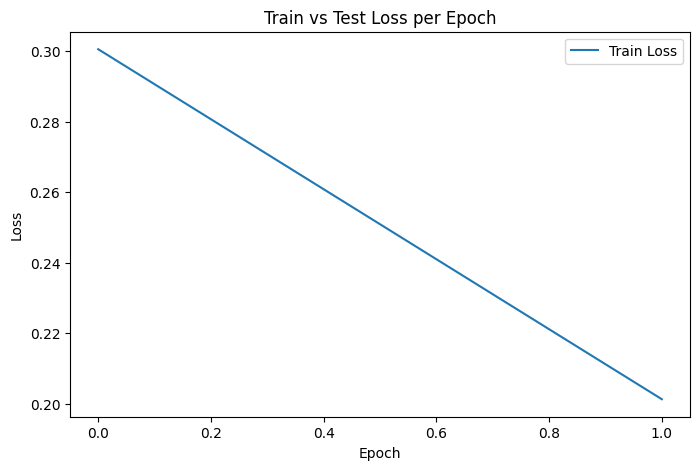

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.show()

In [20]:
items = df["item"].drop_duplicates()
users = df["user"].drop_duplicates()

users_tensor = torch.tensor(users, dtype=torch.long, device=device)
items_tensor = torch.tensor(items, dtype=torch.long, device=device)

In [21]:
u_stack, i_stack, s_stack = model.predict(users_tensor, items_tensor)

In [22]:
users.max().item()

6039

In [23]:
len(users)

5289

In [ ]:
model.score(df) 

,user,top_k_rec_id,top_k_rec_score
0,0,"[1106, 1178, 858, 2203, 253, 0, 2898, 1107, 11...","[6.291012763977051, 5.980100154876709, 5.91796..."
1,5,"[853, 1900, 2203, 1120, 581, 1178, 583, 1106, ...","[4.160531520843506, 4.054254531860352, 4.01917..."
2,7,"[2651, 309, 579, 2557, 513, 1563, 1848, 593, 2...","[5.319990634918213, 5.305647850036621, 5.25653..."
3,8,"[2651, 579, 2557, 309, 2785, 593, 287, 513, 11...","[8.177236557006836, 7.519991874694824, 7.27986..."
4,9,"[1900, 1178, 581, 1899, 574, 1906, 963, 957, 1...","[5.004642009735107, 4.8018646240234375, 4.6815..."
...,...,...,...
5284,4060,"[1106, 1108, 253, 802, 908, 1178, 851, 1124, 8...","[3.1764883995056152, 3.046311140060425, 3.0253..."
5285,3234,"[3341, 2651, 2557, 3550, 2501, 3177, 2748, 338...","[3.965900421142578, 3.5838499069213867, 3.5342..."
5286,3297,"[2501, 2651, 2557, 3341, 3550, 2748, 2374, 248...","[4.658039569854736, 4.599343299865723, 4.44651..."
5287,767,"[3341, 2374, 2557, 3550, 2501, 2651, 3510, 274...","[4.561831474304199, 4.3047356605529785, 4.2296..."


In [29]:
model.score(test_df)

,user,top_k_rec_id,top_k_rec_score
0,5,"[853, 1900, 2203, 1120, 581, 1178, 583, 1106, ...","[4.160531520843506, 4.054254531860352, 4.01917..."
1,8,"[2651, 579, 2557, 309, 2785, 593, 287, 513, 11...","[8.177236557006836, 7.519991874694824, 7.27986..."
2,17,"[1106, 1178, 1120, 253, 1108, 2374, 1107, 1449...","[5.687621593475342, 5.476319789886475, 5.31729..."
3,25,"[583, 525, 339, 2891, 573, 346, 440, 370, 1476...","[4.212156772613525, 3.7768044471740723, 3.7362..."
4,43,"[1178, 1106, 1120, 1025, 253, 1449, 581, 1900,...","[5.137267589569092, 5.043939113616943, 4.96075..."
...,...,...,...
5284,2244,"[2651, 2748, 2501, 3341, 216, 3550, 2557, 2785...","[4.591794013977051, 4.424321174621582, 4.40211..."
5285,1036,"[2651, 2748, 3651, 2785, 3341, 2557, 579, 2944...","[4.574178695678711, 4.207799911499023, 4.17276..."
5286,4060,"[1106, 1108, 253, 802, 908, 1178, 851, 1124, 8...","[3.1764883995056152, 3.046311140060425, 3.0253..."
5287,4895,"[2968, 3651, 2944, 3177, 2651, 2203, 2143, 334...","[3.0234451293945312, 3.0112032890319824, 2.944..."
